微积分的技术 适用于一些 良态的函数.

- 但是， 要存在导数的前提是 , 函数 **连续的， 平滑的**

如果要计算精确的导数, 函数还要有 简单的公式 .

但是, 对于实际中的 大多数数据而言 ， 不会那么的 lucky .

由于 **随机性** 或者 **测量误差** 我们很少能碰见 完全平滑函数 .

这里介绍的技术就是 用1个 简单的函数对混乱的数据 进行建模 这个过程叫做回归 !

我们用 一个真实的数据集作为例子, 这些数据来自 CarGraph .

In [408]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

我们没有办法画出  经过这些点的平滑函数， 而且没有意义

- 大量的异常值
- 少数错误值

我们的目标是找到一个 **近似于** 这些数据的 趋势函数 .

我们的函数 p(x) 接收 里程数 x 作为输入, 并且返回行驶了给定里程的 Car 的典型价格 .

我们从最简单的函数 : 线性函数开始 .

线性函数可以是多种形式.我们用的不是最标准的.

$$
p(x) = ax + b
$$

其中, a 是斜率, b 是 截距 .

选择这个预测函数意味着:

- 新车是 20_000 美元
- 折旧率 或者说 贬值率是 没英里 0.05 美元左右

这些数据可能对 or not ， 很明显 **有问题**, 大多数的点不接近他 .
寻找 a 和 b 的值让 p(x) 尽量的接近趋势 ，这个工作过程就是 **线性回归** .

一旦我们找到了 就说 p(x) 是最佳拟合线 .

我们可以基于历史的数据就直接得到他, 这就是 为什么回归是 机器学习算法的一个 简单例子 :

他根据 **历史的已有数据** 就可以去推断出一种趋势， 用来对新的数据点进行预测 。

我们这里的唯一约束就是， 要寻找一个线性函数 。

- 这不是事实
- 我们暂时的目标不是 完美， 而是 简单

第一件的事情就是 去衡量一个给定的 线性函数， 也就是说， 给定的 a 和 b 对价格的预测要有多好 ！

为此，我们要实现一个函数叫做 , `cost function` 的函数， 它取 p(x) 为输入， 并且返回 1个数， 表示 p(x) 离原始数据有多远 。


然后就可以对任意数 a 和 b, 用这个代价函数来衡量函数 p(x) = ax + b 和 数据的 **拟合程度** .

每一个数对 (a, b) 都对应一个线性函数 ， so 这个任务其实是在 在探索 1个二维的线性空间 .

我们需要的 a 和 b 不仅仅能使 代价函数 变小, 而且能使得它尽可能精确的 最小函数 .

第二个函数叫做 `linear_regression` . 它能自动找到  a 和 b 的最佳值， 也就是所谓的 **最佳拟合线** 。



为此 我们会建立一个一个函数, 计算任意给定的 a 和 b  值的代价, 并且使用 梯度下降的技术让他 最小化 .

In [409]:
from chapters.internal.tools.vectors import *
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


def plot_function(f, xmin, xmax, **kwargs):
    ts = np.linspace(xmin, xmax, 1000)
    plt.plot(ts, [f(t) for t in ts], **kwargs)


def scalar_field_heatmap(f, xmin, xmax, ymin, ymax, xsteps=100, ysteps=100):
    """
    根据函数绘制热力图
    """
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    fv = np.vectorize(f)
    X = np.linspace(xmin, xmax, xsteps)
    Y = np.linspace(ymin, ymax, ysteps)
    X, Y = np.meshgrid(X, Y)
    z = fv(X, Y)
    fig, ax = plt.subplots()
    c = ax.pcolormesh(X, Y, z, cmap='plasma')
    ax.axis([X.min(), X.max(), Y.min(), Y.max()])
    fig.colorbar(c, ax=ax)


def secant_slope(f, xmin, xmax):
    return (f(xmax) - f(xmin)) / (xmax - xmin)


def approx_derivative(f, x, dx=1e-6):
    return secant_slope(f, x - dx, x + dx)


def approx_gradient(f, x0, y0, dx=1e-6):
    partial_x = approx_derivative(lambda x: f(x, y0), x0, dx=dx)
    partial_y = approx_derivative(lambda y: f(x0, y), y0, dx=dx)
    return partial_x, partial_y


def gradient_descent(f, xstart, ystart, tolerance=1e-6):
    x = xstart
    y = ystart
    grad = approx_gradient(f, x, y)
    while length(grad) > tolerance:
        x -= 0.01 * grad[0]
        y -= 0.01 * grad[1]
        grad = approx_gradient(f, x, y)
    return x, y

# 1. 衡量函数的拟合质量

我们编写的函数要适合 各种数据集. 不仅仅是这个集合 .

代价函数有2个输入;

- 测试的函数 f(x)
- 测试的数据集合 . 也就是 已经存在数据 (x, y) 集合 .

代价函数的输出是1个数:

- 衡量 f(x) 的值和正确 y 值 之间的距离 .
- 如果对于每个 x 都有 y = f(x) . 完美的函数 返回的结果为 0 .

2个代价函数 demo:

- `sum_error` : 把 数据集合中的每个 (x, y) 对应的从 f(x) 到 y 的距离加起来 ;
- `sum_square_error` : 把这些距离的 平方加起来 ; 这个比较常用. 我们马上就明白为什么

### 1.1 计算数据和函数的距离

如下 是一个由 (x, y) 值组成的 `Python` 列表 . 组成了 虚构的数据集合 .

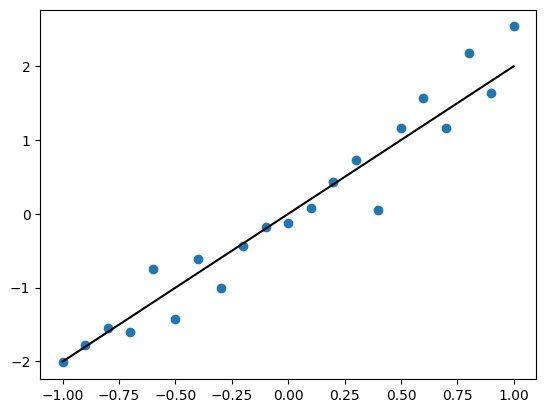

In [410]:
test_data = [
    (-1.0, -2.0137862606487387),
    (-0.9, -1.7730222478628337),
    (-0.8, -1.5510125944820812),
    (-0.7, -1.6071832453434687),
    (-0.6, -0.7530149734137868),
    (-0.5, -1.4185018340443283),
    (-0.4, -0.6055579756271128),
    (-0.3, -1.0067254915961406),
    (-0.2, -0.4382360549665138),
    (-0.1, -0.17621952751051906),
    (0.0, -0.12218090884626329),
    (0.1, 0.07428573423209717),
    (0.2, 0.4268795998864943),
    (0.3, 0.7254661223608084),
    (0.4, 0.04798697977420063),
    (0.5, 1.1578103735448106),
    (0.6, 1.5684111061340824),
    (0.7, 1.157745051031345),
    (0.8, 2.1744401978240675),
    (0.9, 1.6380001974121732),
    (1.0, 2.538951262545233)
]

# 我们尝试用 python 画出来 .
plt.scatter([t[0] for t in test_data], [t[1] for t in test_data])
plot_function(lambda x: 2 * x, -1, 1, c='k')

我们 画了1个 y=2x 的线和 test_data 的数据.

上面的图看拟合不是很明显, 我们这里 换个方式 .

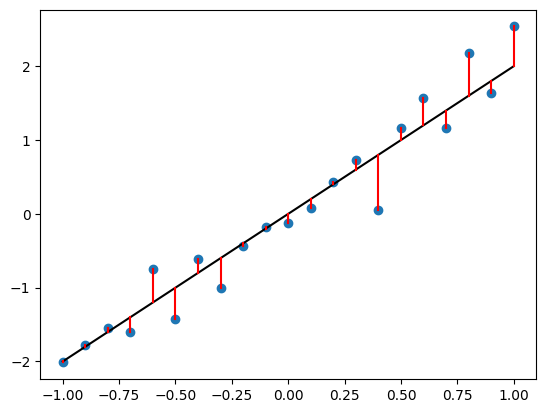

In [411]:
def draw_cost(h, points):
    xs = [t[0] for t in points]
    ys = [t[1] for t in points]

    # 1. 离散的点
    plt.scatter(xs, ys)

    # 2. 函数线
    plot_function(h, min(xs), max(xs), c='k')

    # 3. 每个点中. 从 (x,y) 到 (x, h(x)) 那条 垂直的线
    for (x, y) in points:
        plt.plot([x, x], [y, h(x)], c='r')


draw_cost(lambda x: 2 * x, test_data)

上面的图可以清晰的反映出 cost.

属于 误差较小的 函数

我们再换个函数. 属于 误差较大的 函数 .

误差越大, **越不拟合**

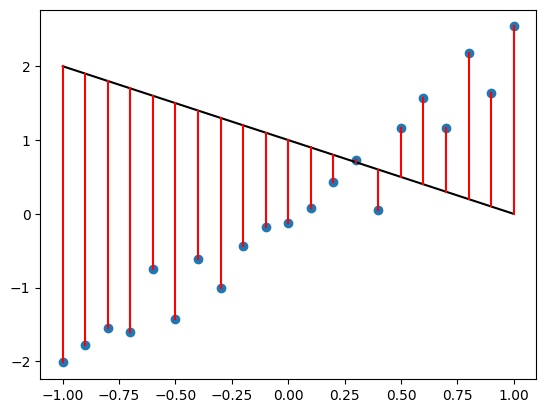

In [412]:
draw_cost(lambda x: 1 - x, test_data)

In [413]:
def sum_error(f, data):
    errors = [abs(f(x) - y) for (x, y) in data]
    return sum(errors)


def f(x):
    return 2 * x


def g(x):
    return 1 - x


print(f"""
f sum error is {sum_error(f, test_data)}
g sum error is {sum_error(g, test_data)}
""")


f sum error is 5.021727176394801
g sum error is 38.47711311130152



总误差小的 能基本认为 更好拟合

### 1.2 计算误差的平方和


实践中使用 平方和来 作为代价函数 有如下理由：

- 平方距离函数 跟 y =  |x| 比, 是一个平滑函数 ;
- 平滑函数 可以用 微积分的知识来处理
- 而且 这个因为使用了 平方， 意味着更大的惩罚 !

In [414]:
def sum_squared_error(f, data):
    squared_errors = [(f(x) - y) ** 2 for (x, y) in data]
    return sum(squared_errors)

这个代价函数 其实也是可视化的

几何上理解 是 以 (f(x) - y) 为正方形 边 的面积 .

In [415]:
def draw_square_cost(h, points):
    xs = [t[0] for t in points]
    ys = [t[1] for t in points]

    # 1. 画出点
    plt.scatter(xs, ys)

    # 2. 画出线
    plot_function(h, min(xs), max(xs), c='k')
    for (x, y) in points:
        e = abs(y - h(x))
        # 3. 画出一条线
        plt.plot([x, x], [y, h(x)], c='r')
        # 4. 填充为正方形
        plt.fill([x, x, x + e, x + e], [h(x), y, y, h(x)], c='r', alpha=0.5)

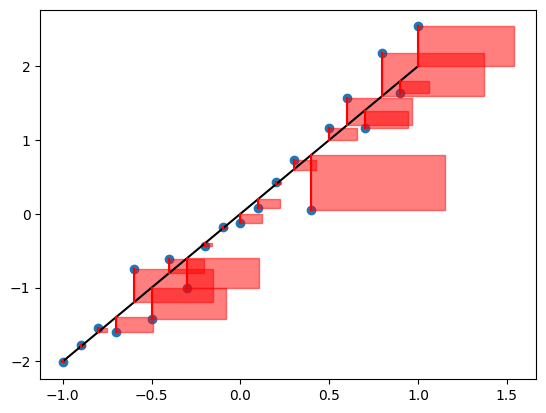

In [416]:
draw_square_cost(lambda x: 2 * x, test_data)

我们用 数据而不是图形来观察 可能更直观 .

正方形之间相互重合 .

In [417]:
print(
    f"""
    2x punished cost is {sum_squared_error(lambda x: 2 * x, test_data)}
    3x punished cost is {sum_squared_error(lambda x: 3 * x, test_data)}
    1-x punished cost is {sum_squared_error(lambda x: 1 - x, test_data)}
    """)


    2x punished cost is 2.105175107540148
    3x punished cost is 8.207913827011087
    1-x punished cost is 97.1078879283203
    


事实上, 改变定义的参数 a 和 b 来移动这条线, 代价函数也会发生平滑的变化 .

### 1.3 计算汽车价格函数的代价


首先要根据经验进行预测 .

- 平均价格是 25_000 美元

$$
p(x) = ax + b
$$

其中 a = -0.2 , b = 25_000 .

In [418]:
def plot_mileage_price(cars):
    """
    函数会画出 汽车对应的点
    """
    prices = [c.price for c in cars]
    mileages = [c.mileage for c in cars]
    plt.scatter(mileages, prices, alpha=0.5)
    plt.ylabel("Price ($)", fontsize=16)
    plt.xlabel("Odometer (mi)", fontsize=16)

In [419]:
def p1(x):
    return 25000 - 0.2 * x

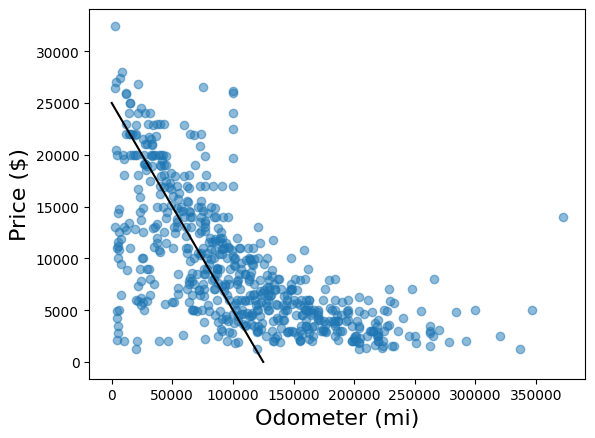

In [420]:
from chapters.e1.car_data import priuses

plot_mileage_price(priuses)
plot_function(p1, 0, 125000, c='k')

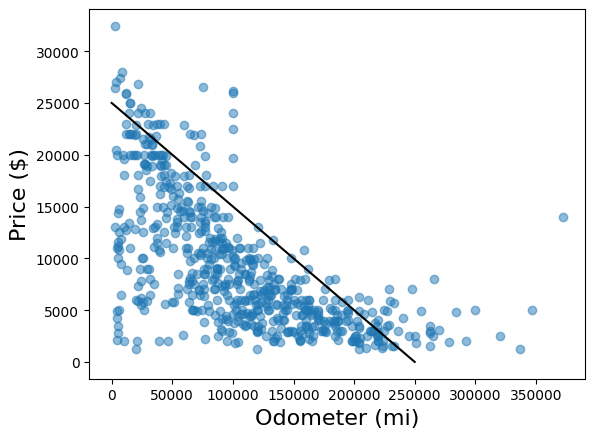

In [421]:
def p2(x):
    return 25000 - 0.1 * x


plot_mileage_price(priuses)
plot_function(p2, 0, 250000, c='k')

上面的2个函数都不完美, 很多的值超出了范围 .

也可以改变初始值 25_000 试下.

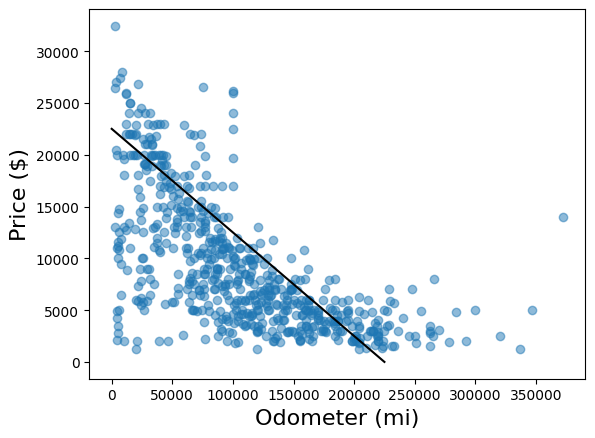

In [422]:
def p3(x):
    return 22500 - 0.1 * x


plot_mileage_price(priuses)
plot_function(p3, 0, 225000, c='k')

我们看下 他们的 代价函数 .

In [423]:
prius_mileage_price = [(p.mileage, p.price) for p in priuses]

print(
    f"""
    p1 is {sum_squared_error(p1, prius_mileage_price)},
    p2 is {sum_squared_error(p2, prius_mileage_price)},
    p3 is {sum_squared_error(p3, prius_mileage_price)},
    """
)


    p1 is 88782506640.24011,
    p2 is 34723507681.56002,
    p3 is 22997230681.56001,
    


发现值都非常的大 其中最小的是 p3

### 1.4 exercises

**exec1:** 创建一组在一条直线上的 数据点. 证明 sum_error 和 sum_squared_error 代价函数对 适当的线性函数都返回 0 .

这个感觉是废话啊 .


**exec2:** 找到一个比 p1,p2,p3 更优秀的 p4 .

In [424]:
def p4(x):
    return 20000 - 0.1 * x

## 2. 探索函数空间

通过上面的例子 ， 应该有一些感觉了 . p(x) = ax + b

线性函数约束下， 我们不断的修改 a 和 b的值, 让我们间接得到 (a , b) -> cost 的关系 .

简单的 线性函数就定了是 二维空间 .

我们设计一个函数 : `coefficient_cost(a, b)` 来计算这个代价 .

我们可以先用前面的 `test_data` 数据集合  来模拟 .

### 2.1 通过原点直线的代价

我们把 `test_data` 拟合到 `f(x) = ax` 函数上 . 只用1个变量, 在 1维空间探索 .

In [425]:
def test_data_coefficient_cost(a):
    def f(x):
        return a * x

    return sum_squared_error(f, test_data)

Text(0.5, 0, 'a')

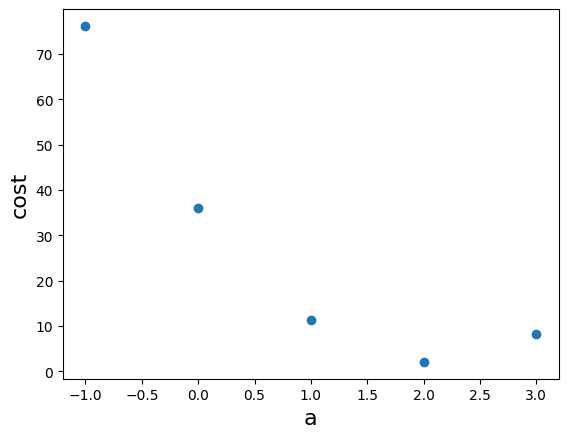

In [426]:
# 我们使用一组数据测试下 .

some_slopes = [-1, 0, 1, 2, 3]
plt.scatter(some_slopes, [test_data_coefficient_cost(a) for a in some_slopes])
plt.ylabel("cost", fontsize=16)
plt.xlabel("a", fontsize=16)

测试发现, a = 2 的时候最小的, 然后开始变大 .

Text(0.5, 0, 'x')

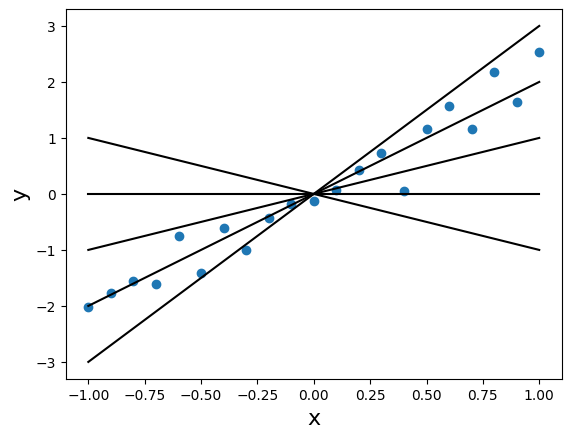

In [427]:
plt.scatter([t[0] for t in test_data], [t[1] for t in test_data])
for a in some_slopes:
    plot_function(lambda x: a * x, -1, 1, c='k')
plt.ylabel("y", fontsize=16)
plt.xlabel("x", fontsize=16)

上图是模拟的线和 离散点的图, 没什么用.

我们尝试 画出 代价的曲线

Text(0.5, 0, 'a')

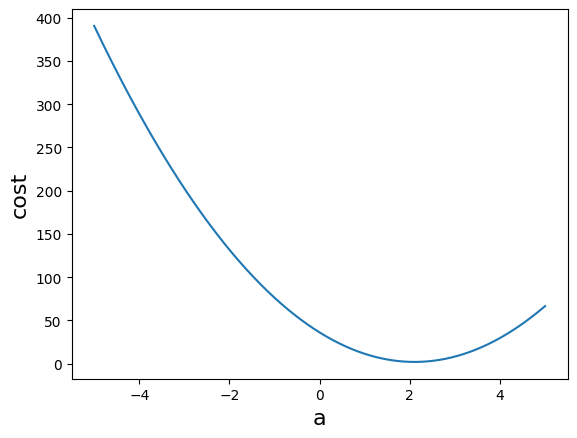

In [428]:
plot_function(test_data_coefficient_cost, -5, 5)
plt.ylabel("cost", fontsize=16)
plt.xlabel("a", fontsize=16)

通过曲线也发现 ， 大约斜率 `=2` 的时候代价最低

### 2.2 所有线性曲线的空间

下面切入到 汽车行业 !

我们要找到 一个函数 $$p(x) = ax + b$$

来根据里程数 预测汽车的价格 .  评估系数 `a` 和 `b` 的不同选择 .

In [429]:
def coefficient_cost(a, b):
    def p(x):
        return a * x + b

    return sum_squared_error(p, prius_mileage_price)

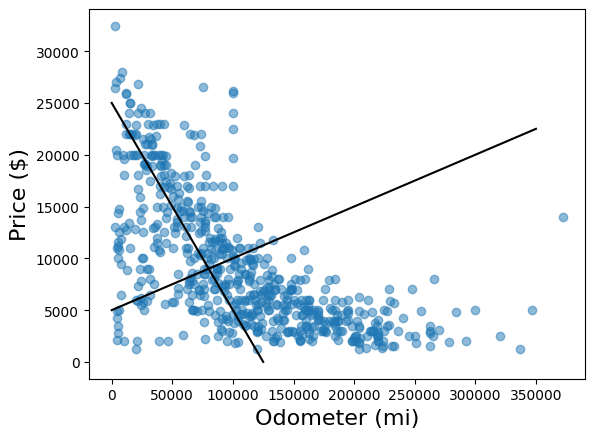

In [430]:
# 1. 画点图
plot_mileage_price(priuses)
# 2. a = 25000 b = -0.20
plot_function(lambda x: 25000 - 0.20 * x, 0, 125000, c='k')
# 3. a = 5000 b = 0.05
plot_function(lambda x: 5000 + 0.05 * x, 0, 350000, c='k')

上面是 2个 拟合直线.

对每个 (a, b) , 我们画出 热力图, 表示 代价值

Text(0.5, 0, 'a')

<Figure size 700x700 with 0 Axes>

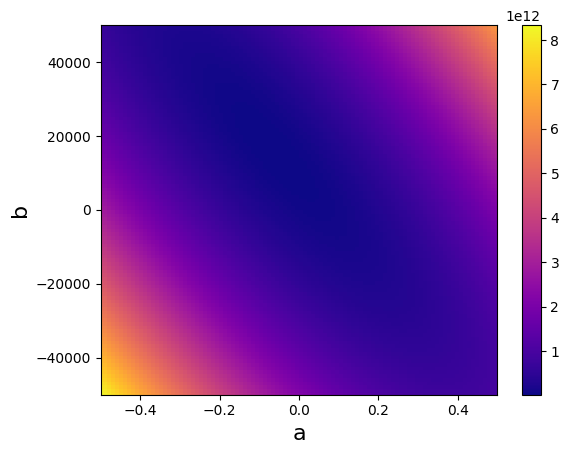

In [431]:
scalar_field_heatmap(coefficient_cost, -0.5, 0.5, -50000, 50000)
plt.ylabel("b", fontsize=16)
plt.xlabel("a", fontsize=16)

1. 注意的是: 热力值越大, 表示 代价越大 .
2. 中间的最暗, 可能比较小一点 .

幸运的, 通过 梯度下降我们可以很快就查到 .

## 3 使用梯度下降法寻找最佳拟合线

我们要找到让 $$p(x) = ax + b$$ 的代价尽可能小的 a 和 b .

使用梯度下降, 和之前的代码几乎一模一样 .


### 3.1 缩放数据

在应用 梯度下降算法之前， 还有1个微妙的细节, 我们处理数据的量级有很大的差异 .

- 折旧率是在 -1 和 0 之间的值;
- 价格是 几万几万 美元
- 代价函数则是 千亿为单位

我们使用 10^(-6) 来计算近似值.  这些数的量级差距很大, 不处理的话. 直接运行. 这个误差可能很大 .这个近似值可能不可靠 .

我们这里没有专业的处理 业务数据 , 仅仅使用数据的缩放来解决问题 .

`p(x) = ax + b` 中 a 代表折旧率, b代表价格 .

- a 的折旧率, 最佳值的量级可能 > 0.5
- b 的价格 理应 < 50_000

通过  a = 0.5 c 和 b = 50000 d 来定义变量 c 和 d .

- 当 c 和 d 的量级 < 1 的时候,  a 和 b  的量级分别小于 0.5 和 50_000 .
- 此时的 代价函数 < 10^13 . 我们把代价函数的结果 除以 10^13. 用 c 和 d 表示 就得到了一个新的代价函数


In [432]:
## 找到这个值 之后, 通过 0.5 *c =a 和 50000 *d = b 来反推即可 .
def scaled_cost_function(c, d):
    return coefficient_cost(0.5 * c, 50000 * d) / 1e13

这个方法非常的落后,  现在有更多科学的算法来做这个事 . 后续再详谈 .

### 3.2 找到并绘制最佳拟合线

我们要 优化的函数是 `scaled_cost_function` . 可以期望 |c| < 1  , |d| < 1 .

因为最优的 c 和 d 离原点很近, 所以可以从 (0, 0) 开始进行梯度下降 . 执行下面的代码可以得到最小值 .

不过需要运行一段时间, 具体执行多久取决于你使用的机器 .

In [433]:
# 我们从原点出发 一路梯度下降
c, d = gradient_descent(scaled_cost_function, 0, 0)

(c, d)

(-0.12111901781166344, 0.3149542288803281)

In [434]:
# 重新找到  a 和 b
a = 0.5 * c
b = 50000 * d
(a, b)

(-0.06055950890583172, 15747.711444016404)

因此函数近似是:

$$
p(x) = -0.0606 \cdot x + 15700
$$

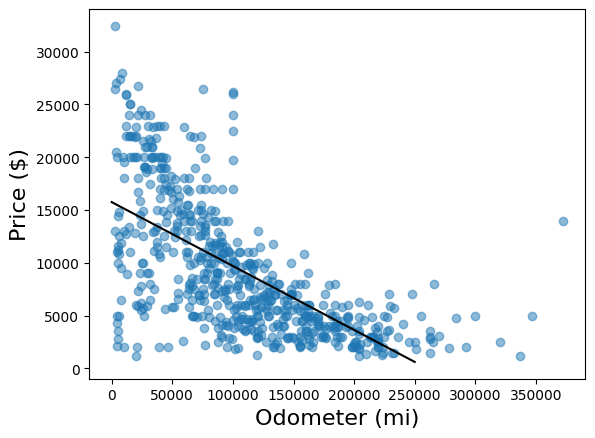

In [435]:
plot_mileage_price(priuses)


def p(x):
    return a * x + b


# 画出对应的点和函数
plot_function(p, 0, 250000, c='k')

在线性函数中 看起来比之前的都要好一些 .

我们量化下

In [436]:
coefficient_cost(a, b)

14536218169.40348

计算线性回归来获得 最佳拟合线有很多方法, 其中有一些优化过的 `python` 库 .

- 不管使用任何一种方法， 都应该得到 相同的线性函数 让误差最小化 .
- 梯度下降法 仅仅是其中的一种 .
    - 目前我们只会 这一种
    - 而且拥有高度的推广性

后续 我们都会用到 梯度下降 .

### 3.3 exercises

**exec1:**  使用梯度下降法找到测试数据的 最佳拟合曲线 .

- 结果应该在 2x+0 附近
- 不完全是 在他附近生成的

数据量级差不多. 就不做数据缩放了 .

In [437]:
def test_data_linear_cost(a, b):
    def f(x):
        return a * x + b

    return sum_squared_error(f, test_data)


## 梯度下降计算
gradient_descent(test_data_linear_cost, 0, 0)

(2.1037182061463406, 0.0021207385936250667)

<Figure size 700x700 with 0 Axes>

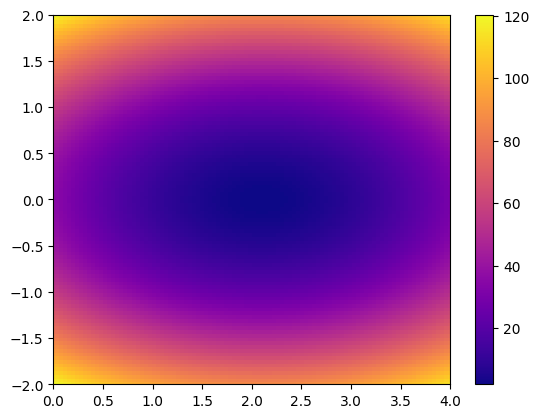

In [438]:
# 画个热力图 同时观察
scalar_field_heatmap(test_data_linear_cost, 0, 4, -2, 2)

对比观察 发现在 2.0. 0 附近确实是的! 颜色也比较深 .

## 4. 非线性函数拟合

我们目前的工作中, 其实没有要求 汽车的价格函数是线性的.

- 选择线性函数是因为简单
- 其他都可以
    - 正态分布函数 ?
    - 指数函数 ?

$$
p(x) = qe^{rx}
$$

### 4.1 理解指数函数的行为

快速回顾下 指数函数 .

- 基数 > 1 : x 越大越大 ;
- 基数 < 1 : x 越小则越小 ;

指数衰减: exponential decay . 更像我们的价格折旧模型 .

$$
(1/2)^x
$$

- 意味着每个固定大小的 x 区间, 价格函数以 **相同比例** 递减 .
- 每5w里 损失一半 .10w里就是 1/4


直观上看， 可能更符合现实 . 而且 用指数模型明显永远是正数， 线性一定能搞成 负数 .


在通用的模型

$$
p(x) = qe^{rx}
$$

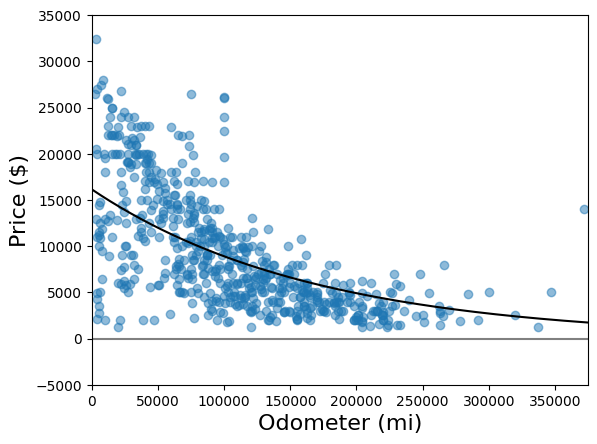

In [439]:
from math import exp

plot_mileage_price(priuses)
plt.ylim(-5000, 35000)
plt.xlim(0, 375000)
plot_function(lambda x: 0, -50000, 400000, c='gray')
q, r = (16133.220556990309, -5.951793936498175e-06)

## 指数函数
plot_function(lambda x: q * exp(r * x), 0, 375000, c='k')

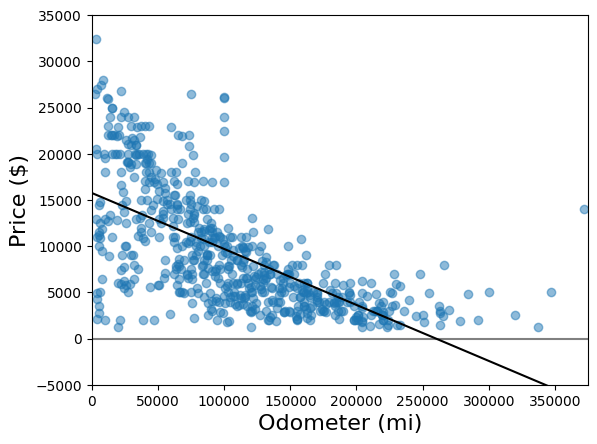

In [440]:
plot_mileage_price(priuses)
plt.ylim(-5000, 35000)
plt.xlim(0, 375000)
plot_function(lambda x: 0, -50000, 400000, c='gray')

## 线性函数
plot_function(lambda x: a * x + b, 0, 375000, c='k')

此时 :

- q 是 x = 0 的时候的值, 仍然表示最开始的价格
- r 是负数, 表示衰减 . 折旧率 .

### 4.2 寻找最佳拟合的指数函数

In [441]:
## 使用指数函数来计算折旧率
def exp_coefficient_cost(q, r):
    def f(x):
        return q * exp(r * x)

    return sum_squared_error(f, prius_mileage_price)

同样会面临 数据缩放的问题 .

- 对于 q, 希望能接近 线性模型中的 b, 安全起见， 使用 0 - 30_000 的范围
- 对 r 则非常的微妙, x 每增加 1/r 个单位 . 价格就减少到之前的 1/e . 大约是 0.36 .

我们保守一些, 假设一辆车在行驶了 最初的 10_000 英里后, 价格降低为之前的 1/e , 原价的 36% . 这样的话 . r = 10^(-4) 左右 .

<Figure size 700x700 with 0 Axes>

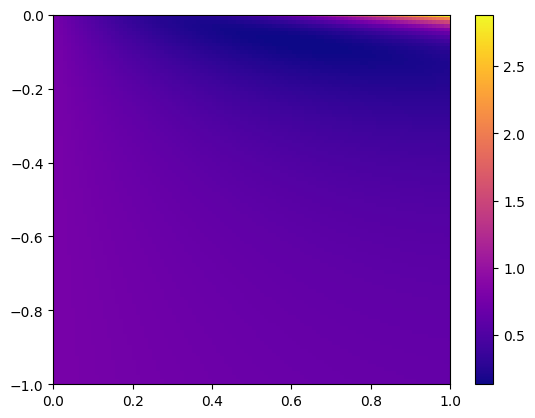

In [444]:
def scaled_exp_coefficient_cost(s, t):
    return exp_coefficient_cost(30000 * s, 1e-4 * t) / 1e11


## 缩放后是 0->-1 和 0->1 2个区间
scalar_field_heatmap(scaled_exp_coefficient_cost, 0, 1, -1, 0)

In [445]:
## 梯度下降法去寻找 s, t 和上图对比着看 大约是最暗的地方
s, t = gradient_descent(scaled_exp_coefficient_cost, 0, 0)
(s, t)

(0.6235404892846866, -0.07686877731236057)

In [446]:
q, r = 30000 * s, 1e-4 * t
(q, r)

(18706.2146785406, -7.686877731236057e-06)

In [448]:
print(
    f"""
    线性的是: 14536218169,
    指数的是 :{exp_coefficient_cost(q, r)}
    """
)


    线性的是: 14536218169,
    指数的是 :13497959831.297215
    


看上去好了一些， 但是不大， 但是还是 稍微好一些 .

像用指数函数这种 只是线性回归函数的 一种的遍体， 还有非常多的其他的函数， 由2个以上的 数定义的函数 等等 .

### 4.3 exercises

...

## 小结

- 回归是 找到1个模型来描述各种数据集合之间的关系的过程 ;
- 线性回归是用线性函数 去回归的方法 ;
- 对于一组由许多 (x, y) 数据点组成的数据,  不太可能有一条线穿过所有的点 ;
- 对于模型函数 (x, y) 可以通过测量 指定点 (x, y) 的 f(x) 和 y 之间的距离来 衡量它和数据的接近程度 ;
- 衡量模型对数据集 拟合程度的函数 称为 代价函数 . 一个常用的代价函数是 点 (x, y)  到相应模型值 f(x) 的距离的平方和 ;
- 考虑到 f(x) 的线性函数, 每一对系数 (a, b) 都可以唯一定义了一个线性函数 . 这样的 二元组可以生成 一个二维空间, 因此需要在二维空间中 探索 拟合线 ;
- 取一对系数 (a, b) 然后计算 ax + b 的代价的函数, 输入是1个点,  输出是一个数. 把这个代价函数 最小化, 就能得到最佳拟合函数的 系数 ;
- 当 x 以恒定 的量 变化的时候 , 线性函数 p(x)  以恒定的比值 增加或者减小 ;
- 要将指数 函数拟合到数据上 过程类似